# Simple Linear Regression

Many problems we find in science, engineering, and business are of the following form. 
We have a variable, $x$ and we want to model/predict a variable, $y$.

Importantly, these variables are paired like $(x_1,y_1)(x_2,y_2)(x_3,y_3)...$.

In the most simple scenario, known as simple linear regression, both and are unidimensional continuous random variables. 

By continuous, we mean a variable represented using real numbers (or floats,if you wish), and using NumPy, you will represent the variables or as one-dimensional arrays. 

Common names for the variable(s) we are trying to predict:
* target
* dependent
* predicted
* outcome
* output

Common names for the variable(s) we are using to make the prediction:
* independent
* predictor
* input
* features

When $X$ is a matrix, it is called multiple linear regression.

# The core of linear regression models
A traditional model is of the form:

$ y_i = \alpha + x_i * \beta $

This equation states that there is a linear relationship between $x$ and $y$, and has the following parameters:
* $\beta$ controls the slope
* $\alpha$ is the intercept - tells us $y_i$ when $x_i=0$ 

To find the parameters we can treat it as an optimization problem, find a value for $\alpha$ and $\beta$ such that the distance from the line to each point in the dataset is minimal.  Such an approach is taken in deep learning frameworks such as Tensorflow and other approaches that use gradient descent.  

An alternative approach to optimization is to generate a fully probabilistic model. Thinking probabilistically gives us several advantages; we can obtain the best values of and  (the same as with optimization methods) together with an estimation of the uncertainty we have about the parameter's values. Optimization methods require extra work to provide this information.  Probabalistic thinking also allows us to provide a level of uncertainty regarding our confidence in an prediction.  Optimization methods don't allow for this.

Finally, and most important, the underlying matrix manipulations and multiplications that are done in tools such as PyMC3 are the same as what is done in a deep learning framework, allowing us to take advantage of gpu computation.

Really the only difference is in deep learning we define an architecture such that the structure of the problem can be learned automatically as part of the learning process.  This works great when there is lots of data.  In a probabalistic approach, we place assumptions (also called priors) that allow us to constrain the solution space.  We spend much more time modeling the solution in Bayesian approaches, and we gain much more explainability in the process.  Concequently, Bayesian approaches work when there is less data, or data is sparce.

The probabalistic version of the linear model is:

$ y \sim N(\mu = \alpha + x * \beta, \epsilon )  $

where:
* $ y  $ is the target
* $ N()  $ is a Gaussian distribution (of the error)
* $ \alpha + x * \beta $ terms that represent the mean
* $ \epsilon  $ is the standard deviation, or error

Note, it need not be that errors are distributed in a Gaussian, it just makes sense in a lot of cases because natural processes tend to have Gaussian error due to the fact that measurements of distance are measured via the triangle inequality... so the Gaussian fits nicely when that is the case.

In [27]:
import numpy as np
import pandas as pd
import pymc3 as pm
from numpy import random
import seaborn as sb
import matplotlib.pyplot as plt
import arviz as az


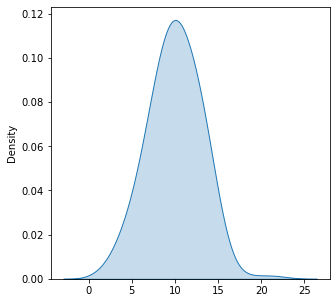

In [21]:
data = np.random.normal(10,3,300) #Generating data.
plt.figure(figsize = (5,5))
sb.kdeplot(data , bw_method = 0.5 , fill = True)
plt.show()

In [6]:
random.seed(42)
print(random.standard_cauchy(10), random.standard_cauchy(10))
random.seed(42)
print(random.standard_cauchy(20))

[-3.59249748  0.42526319  1.00007012  2.05778128 -0.8652948   0.99503562
 -0.12646463  3.06767933 -3.22303808  0.64293825] [-6.49159706 -0.04739659 -4.9077715  -3.06361365  2.05914145 -0.32484678
  0.01276079 -0.67375123 -0.106581   -6.74681353]
[-3.59249748  0.42526319  1.00007012  2.05778128 -0.8652948   0.99503562
 -0.12646463  3.06767933 -3.22303808  0.64293825 -6.49159706 -0.04739659
 -4.9077715  -3.06361365  2.05914145 -0.32484678  0.01276079 -0.67375123
 -0.106581   -6.74681353]


## Kruschke diagram of the basic linear model



<img src="./linearRegression.png">

This diagram states that we believe that the data is normaly distributed, but we don't know the mean, $\mu$ or the variance, $\sigma$.  We set priors as follows:
* $\alpha \sim N(\mu_\alpha, \sigma_\alpha) $  : the intercept prior
* $\beta \sim N(\mu_\beta, \sigma_\beta) $ : the slope prior
* $\epsilon \sim |N(0,\sigma_\epsilon)| $ : error term

again the model is: 
$ y =  \beta x + \alpha \pm \epsilon   $

Now that we have defined the model, we need the data to feed the model. Once again, we are going to rely on a synthetic data set to build intuition on the model.  One advantage of a synthetic dataset is that we know the correct values of the parameters and we can check if we are able to recover them with our models:

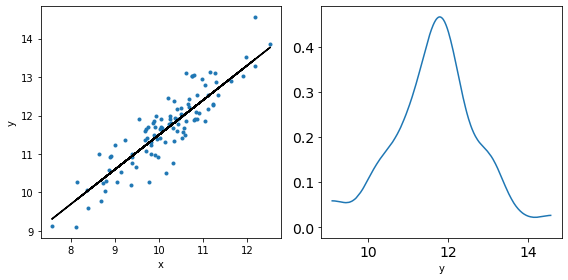

In [25]:
np.random.seed(1)
N = 100
alpha_real = 2.5 
beta_real = 0.9
eps_real = random.normal(0, 0.5, size=N)
x = np.random.normal(10, 1, N) 
y_real = alpha_real + beta_real * x
y = y_real + eps_real
_, ax = plt.subplots(1, 2, figsize= (8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel ('x')
ax[0].set_ylabel('y', rotation=90)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()

In [28]:
# Linear Regression model
# note mu is expessed in the model as a deterministic variable
# reflecting that we have already written in mathematical notation
# and in the Kruschke diagram (above)
with pm.Model() as model_g:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    trace_g = pm.sample(2000, tune=1000)

/Users/m102417/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [epsilon, beta, alpha]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.8868607517684616, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [30]:
# instead of including a deterministic variable for mu, 
# we could have done this:
#y_pred = pm.Normal('y_pred', alpha + beta * x, sd=epsilon, observed=y)

/Users/m102417/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff6e564c310>,
      dtype=object)

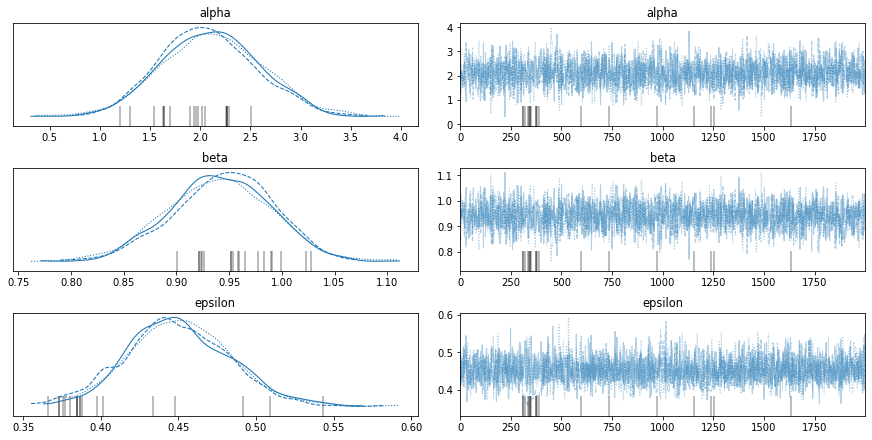

In [29]:
# generate trace plot
az.plot_trace(trace_g, var_names=['alpha', 'beta', 'epsilon'])

## Linear models and high autocorrelation
Linear models lead to a posterior distribution where $\alpha$ and $\beta$ are highly correlated.  Specifically, all lines are constrained to pass through the mean of the data.  This is true for the least square method (and it's assumptions).  Bayesian methods can relax this constraint.  In later examples we will see  we will get lines around the mean values of x and y and not exactly through the mean.  If we use strong priors, we could end up with lines far away from the mean aof ax and y.  The idea of Autocorrelation is related to the line spinning around a more or less defined point as seen in the plot below.

/Users/m102417/anaconda3/lib/python3.8/site-packages/arviz/plots/pairplot.py:185: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(
/Users/m102417/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


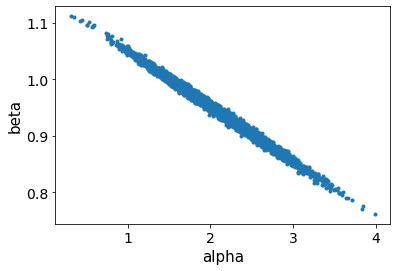

In [31]:
az.plot_pair(trace_g, var_names=['alpha', 'beta'], plot_kwargs={'alpha': 0.1})